# Rock-paper-scissors!

Funny Friday! A rock-paper-scissors robot project built on TensorFlow with about 200 U$ in hardware with among other things an Arduino Bit (microcontroller), a bend sensor to build an homemade sensor-glove and a Servo (motor). 

By Kaz Sato, Developer Advocate, Google Cloud.

[A blog post](https://goo.gl/ahwAjg)

[A video demo on YouTube](https://goo.gl/nQuNjB)

The [GitHub companion code repo](https://goo.gl/Hu5M2u) with an iPython Notebook to train the TensorFlow model, Arduino code and data.

## Read glove sensor data

In [2]:
# import glove sensor data from CSV files
from __future__ import print_function
import numpy as np
g_data_r = np.genfromtxt("glove_rock.csv", dtype=np.float, delimiter=",")
g_data_p = np.genfromtxt("glove_paper.csv", dtype=np.float, delimiter=",")
g_data_s = np.genfromtxt("glove_scissors.csv", dtype=np.float, delimiter=",")

# merge all to g_data
g_data = np.append(g_data_r, g_data_p, axis=0)
g_data = np.append(g_data, g_data_s, axis=0)
print("Glove sensor data: \n" + str(g_data))

Glove sensor data: 
[[ 1019.   492.   739.]
 [ 1023.   492.   737.]
 [ 1019.   491.   738.]
 ..., 
 [  582.     0.   441.]
 [  583.     0.   442.]
 [  584.     0.   441.]]


## Create labels

In [3]:
# create arrays for labels
g_label_r = np.tile([1, 0, 0], (g_data_r.shape[0], 1))
g_label_p = np.tile([0, 1, 0], (g_data_p.shape[0], 1))
g_label_s = np.tile([0, 0, 1], (g_data_s.shape[0], 1))
g_label = np.append(g_label_r, g_label_p, axis=0)
g_label = np.append(g_label, g_label_s, axis=0)
print("Glove posture labels: \n" + str(g_label))

Glove posture labels: 
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ..., 
 [0 0 1]
 [0 0 1]
 [0 0 1]]


## Standardize data

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
g_data = scaler.fit_transform(g_data)
print("Standardized Glove data: \n" + str(g_data))

Standardized Glove data: 
[[ 0.99608993  0.7872      0.85730858]
 [ 1.          0.7872      0.8549884 ]
 [ 0.99608993  0.7856      0.85614849]
 ..., 
 [ 0.56891496  0.          0.51160093]
 [ 0.56989247  0.          0.51276102]
 [ 0.57086999  0.          0.51160093]]


## Plot the data

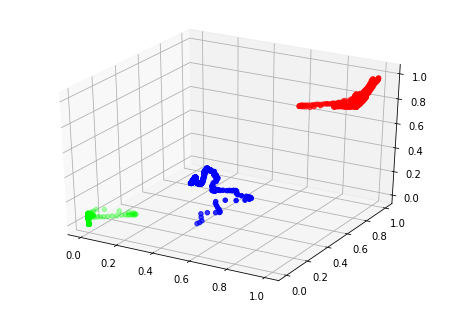

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(g_data[:,0], g_data[:,1], g_data[:,2], c=g_label)
plt.show()

## Define a linear model

In [6]:
# define the model
import tensorflow as tf
weights = tf.Variable(tf.zeros([3, 3]), dtype=tf.float32)
biases = tf.Variable(tf.zeros([3]), dtype=tf.float32)
glove_data = tf.placeholder(tf.float32)
rps_data = tf.matmul(glove_data, weights) + biases

# define the loss
rps_labels = tf.placeholder(tf.float32)
loss = tf.losses.softmax_cross_entropy(onehot_labels=rps_labels, logits=rps_data)

## Train the model

In [8]:
# define an optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=1).minimize(loss)

# create a Session
sess = tf.Session()

# init the variables
initializer = tf.global_variables_initializer()
sess.run(initializer)

# train the model
for i in range(10001):
  
  # train the model
  sess.run(optimizer, {glove_data: g_data, rps_labels: g_label})

  # print current loss
  if i % 1000 == 0:
    l = sess.run(loss, {glove_data: g_data, rps_labels: g_label})
    print("steps = {}, loss = {:f}".format(i, l))

steps = 0, loss = 0.978381
steps = 1000, loss = 0.010096
steps = 2000, loss = 0.005078
steps = 3000, loss = 0.003402
steps = 4000, loss = 0.002562
steps = 5000, loss = 0.002057
steps = 6000, loss = 0.001719
steps = 7000, loss = 0.001478
steps = 8000, loss = 0.001296
steps = 9000, loss = 0.001154
steps = 10000, loss = 0.001041


## Print Arduino code for the trained parameters

In [9]:
# print weights
print("float weights[3][3] = {")
for v in sess.run(weights):
  print("  {{{:f},{:f},{:f}}},".format(v[0], v[1], v[2]))
print("};\n")

# print biases
v = sess.run(biases)
print("float biases[3] = {{{:f},{:f},{:f}}};\n".format(v[0], v[1], v[2]))

# print scaling
v = scaler.scale_
print("float scaling[3] = {{{:f},{:f},{:f}}};\n".format(v[0], v[1], v[2]))

float weights[3][3] = {
  {3.007062,-9.370442,6.363343},
  {10.726247,-0.494134,-10.232146},
  {3.132924,-6.927680,3.794739},
};

float biases[3] = {-5.709809,6.722830,-1.013041};

float scaling[3] = {0.000978,0.001600,0.001160};



# Visualization

## Plot probability distribution

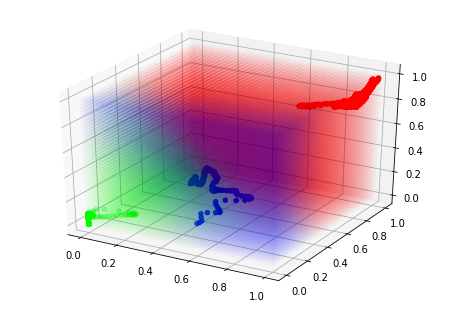

In [10]:
# generate 3D grid positions
pos = [[x,y,z]
       for x in np.linspace(g_data[:,0].min(), g_data[:,0].max(), 40)
       for y in np.linspace(g_data[:,1].min(), g_data[:,1].max(), 40)
       for z in np.linspace(g_data[:,2].min(), g_data[:,2].max(), 40)]

# get softmax value for each position
colors = sess.run(tf.nn.softmax(rps_data), {glove_data: pos})

# get x, y, z values for each position
xs = [x for [x,y,z] in pos]
ys = [y for [x,y,z] in pos]
zs = [z for [x,y,z] in pos]

# plot 3D scatter graph with softmax value
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(xs, ys, zs, c=colors, marker='o', alpha=0.02)
ax.scatter(g_data[:,0], g_data[:,1], g_data[:,2], c=g_label)
plt.show()

## Visualizing "glove space" to "rps space"

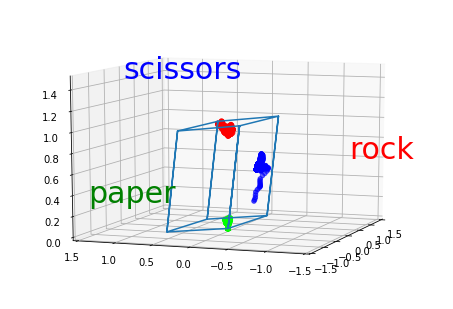

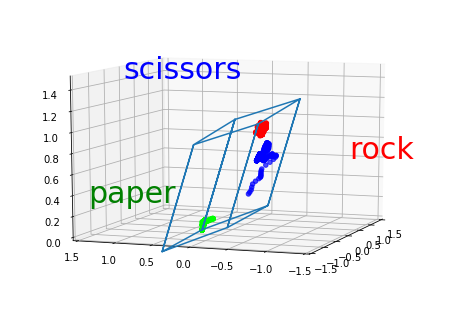

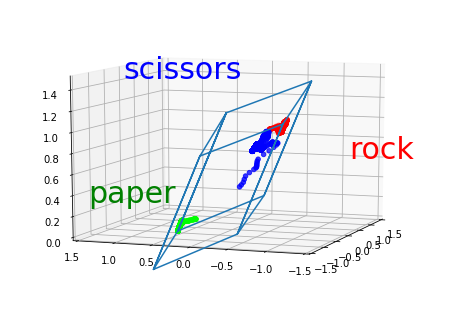

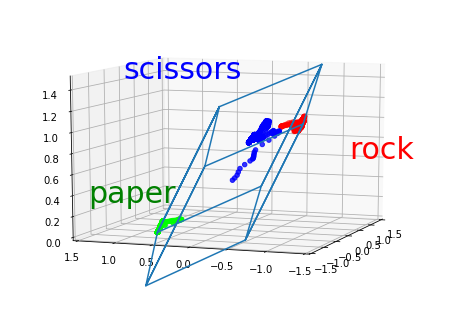

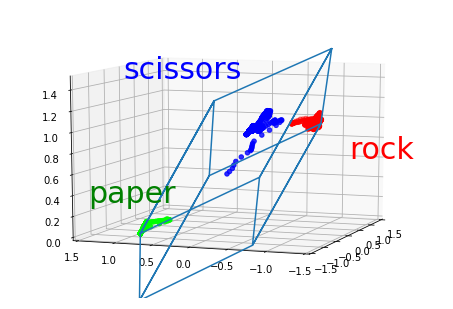

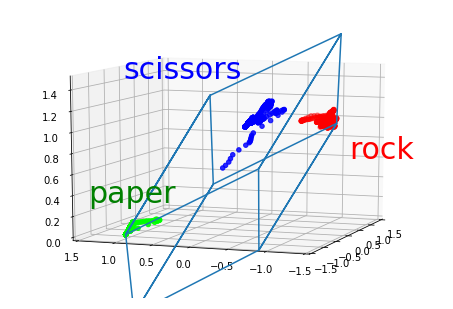

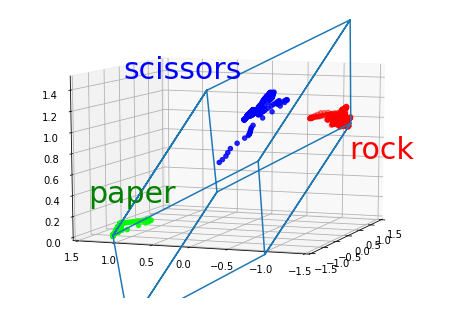

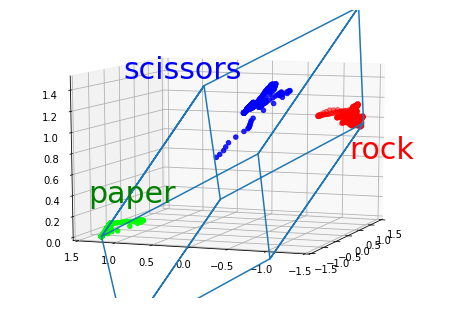

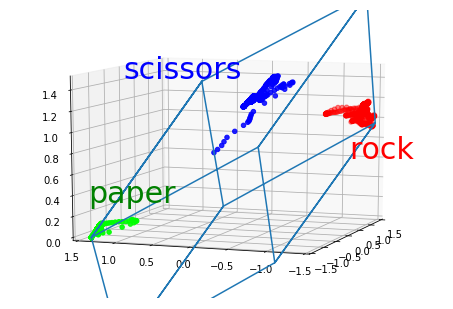

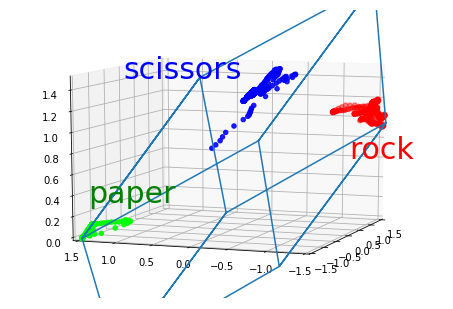

In [11]:
# define the model
import tensorflow as tf
weights = tf.Variable(tf.eye(3), dtype=tf.float32)
biases = tf.Variable(tf.zeros([3]), dtype=tf.float32)
glove_data = tf.placeholder(tf.float32)
rps_data = tf.matmul(glove_data, weights) + biases

# define the loss
rps_labels = tf.placeholder(tf.float32)
loss = tf.losses.softmax_cross_entropy(onehot_labels=rps_labels, logits=rps_data)

# define the optimizer
optimizer = tf.train.GradientDescentOptimizer(1).minimize(loss)

# init a Session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

xmin = g_data[:,0].min()
xmax = g_data[:,0].max()
ymin = g_data[:,1].min()
ymax = g_data[:,1].max()
zmin = g_data[:,2].min()
zmax = g_data[:,2].max()

grid = [
  [xmin, ymin, zmin],
  [xmin, ymin, zmax],
  [xmin, ymin, zmin],
  [xmax, ymin, zmin],
  [xmax, ymin, zmax],
  [xmax, ymin, zmin],
  [xmax, ymax, zmin],
  [xmax, ymax, zmax],
  [xmax, ymax, zmin],
  [xmin, ymax, zmin],
  [xmin, ymax, zmax],
  [xmin, ymax, zmin],
  [xmin, ymin, zmin],
  [xmin, ymin, zmax],
  [xmax, ymin, zmax],
  [xmax, ymax, zmax],
  [xmin, ymax, zmax],
  [xmin, ymin, zmax],
]

# train the model
for i in range(30):
  
  # train the model
  sess.run(optimizer, {glove_data: g_data, rps_labels: g_label})

  # print current loss
  if i % 3 == 0:
    l = sess.run(rps_data, {glove_data: g_data, rps_labels: g_label})
    grid_t = sess.run(rps_data, {glove_data: grid, rps_labels: g_label})
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(elev=10, azim=20)
    ax.set_xlim3d(1.5, -1.5, auto=False)
    ax.set_ylim3d(1.5, -1.5, auto=False)
    ax.set_zlim3d(0, 1.5, auto=False)
    ax.text(1.2, -1.2, 0.6, "rock", fontsize=30, color="red")
    ax.text(-1.2, 1.5, 0.3, "paper", fontsize=30, color="green")
    ax.text(-1.2, 1.0, 1.5, "scissors", fontsize=30, color="blue")
    ax.scatter(l[:,0], l[:,1], l[:,2], c=g_label)
    ax.plot(grid_t[:,0], grid_t[:,1], grid_t[:,2])
    plt.show()